In [16]:
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
# pip install geopandas
import geopandas as gpd
from shapely.geometry import Polygon
import os
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import pyproj
from shapely.ops import transform
from functools import partial

In [12]:
parent_directory = os.path.dirname(os.getcwd())

blocks_file_path = parent_directory + '/census2020_blockgroups.json'
blocks = gpd.read_file(blocks_file_path)

In [13]:
# convert block polygons to LatLong

# Define the UTM projection for Zone 19T (for Boston, MA)
state_plane = pyproj.Proj(init='epsg:2249', preserve_units=True)

# Define a function to convert UTM coordinates to latitude and longitude
def utm_to_latlon(x, y):
    lon, lat = state_plane(x, y, inverse=True)
    return lon, lat

# Define a function to transform coordinates to UTM and then to latitude and longitude
def transform_to_latlon(geom):
    transformed_geom = transform(partial(pyproj.transform, state_plane, pyproj.Proj(init='epsg:4326')), geom)
    return transformed_geom

for i, row in blocks.iterrows():
    poly = row['geometry']
    # Check if the geometry is a MultiPolygon
    if poly.geom_type == 'MultiPolygon':
        # If it's a MultiPolygon, iterate through individual polygons
        polygon_latlon = []
        for single_poly in poly.geoms:
            for ring in single_poly.exterior.coords:
                lat, lon = utm_to_latlon(ring[0], ring[1])
                polygon_latlon.append((lat, lon))
        formatted_polygon = MultiPolygon([Polygon(polygon_latlon)])
    else:
        polygon_latlon = []
        for ring in poly.exterior.coords:
            lat, lon = utm_to_latlon(ring[0], ring[1])
            polygon_latlon.append((lat, lon))
        formatted_polygon = Polygon(polygon_latlon)

    blocks.at[i, 'formatted_polygon'] = formatted_polygon

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


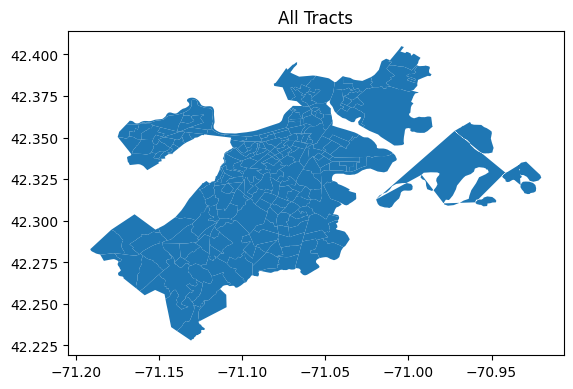

In [14]:
from shapely.ops import unary_union
grouped_tracts = blocks.groupby('TRACTCE20')['formatted_polygon'].apply(unary_union).reset_index()
tracts_gdf = gpd.GeoDataFrame(grouped_tracts, geometry='formatted_polygon')

# Plot the polygons
tracts_gdf.plot()
plt.title('All Tracts')
plt.show()

In [17]:
from shapely.geometry import Point

In [18]:
# define circle for each tract: centroid point + defined radius
import math

RADIUS = 1 # in km

def km_to_degrees(km, latitude):
    # Radius of the Earth in meters
    earth_radius = 6378137.0

    # Calculate the circumference of the Earth at given latitude
    circumference = 2 * math.pi * earth_radius * math.cos(math.radians(latitude))

    # Convert meters to degrees of longitude
    degrees_per_meter = 360.0 / circumference
    degrees = km *1000 * degrees_per_meter

    return degrees

for i, row in grouped_tracts.iterrows():
    # Find the center point (centroid) of the combined polygon
    center_point = row['formatted_polygon'].centroid
    lat = center_point.y
    # Define radius of the circle
    radius_km = RADIUS  # Change this value to set the radius of the circle
    radius_deg = km_to_degrees(radius_km, lat)
    # Create a circle around the center point with the specified radius
    circle = Point(center_point).buffer(radius_deg)
    grouped_tracts.at[i, 'circle'] = circle

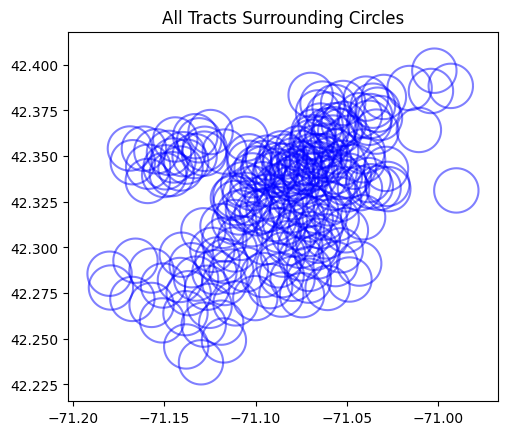

In [19]:
tracts_gdf = gpd.GeoDataFrame(grouped_tracts, geometry='circle')

# Plot the polygons
tracts_gdf.plot(facecolor='none', edgecolor='blue', linewidth=1.5, alpha=0.5)
plt.title('All Tracts Surrounding Circles')
plt.show()

In [22]:
file_path = '/MBTA_Rapid_Transit_Stop_Distances.csv'
mbta_data = pd.read_csv(file_path)

In [4]:
mbta_data.head()

,route_id,direction_id,route_pattern_name,from_stop_id,from_station_id,from_stop_name,to_stop_id,to_station_id,to_stop_name,from_to_meters,cumulative_meters,from_to_miles,cumulative_miles,ObjectId
0,Blue,0,Wonderland - Bowdoin,70059,place-wondl,Wonderland,70057,place-rbmnl,Revere Beach,648.079540,648.079540,0.402698,0.402698,1
1,Blue,0,Wonderland - Bowdoin,70057,place-rbmnl,Revere Beach,70055,place-bmmnl,Beachmont,1198.237979,1846.317519,0.744551,1.147249,2
2,Blue,0,Wonderland - Bowdoin,70055,place-bmmnl,Beachmont,70053,place-sdmnl,Suffolk Downs,849.599507,2695.917026,0.527917,1.675165,3
3,Blue,0,Wonderland - Bowdoin,70053,place-sdmnl,Suffolk Downs,70051,place-orhte,Orient Heights,745.434098,3441.351124,0.463191,2.138356,4
4,Blue,0,Wonderland - Bowdoin,70051,place-orhte,Orient Heights,70049,place-wimnl,Wood Island,1742.139558,5183.490682,1.082515,3.220872,5


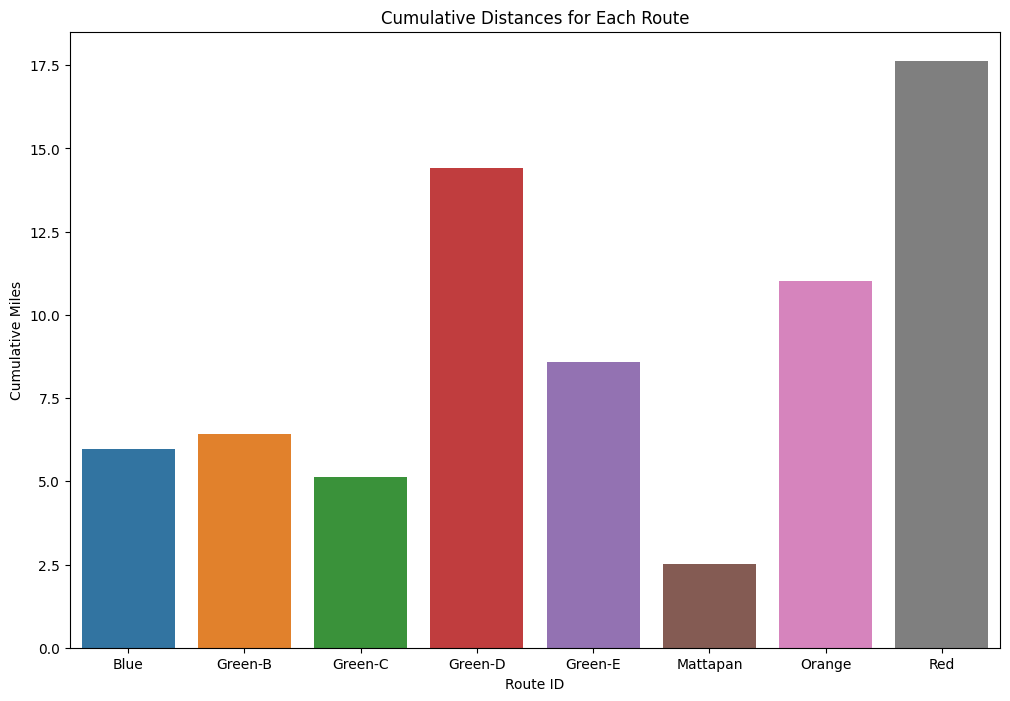

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by route_id, summing the cumulative distances
cumulative_distances = mbta_data.groupby('route_id')['cumulative_miles'].max().reset_index()

# Plotting the cumulative distances for each route
plt.figure(figsize=(12, 8))
sns.barplot(x='route_id', y='cumulative_miles', data=cumulative_distances)
plt.title('Cumulative Distances for Each Route')
plt.xlabel('Route ID')
plt.ylabel('Cumulative Miles')
plt.show()


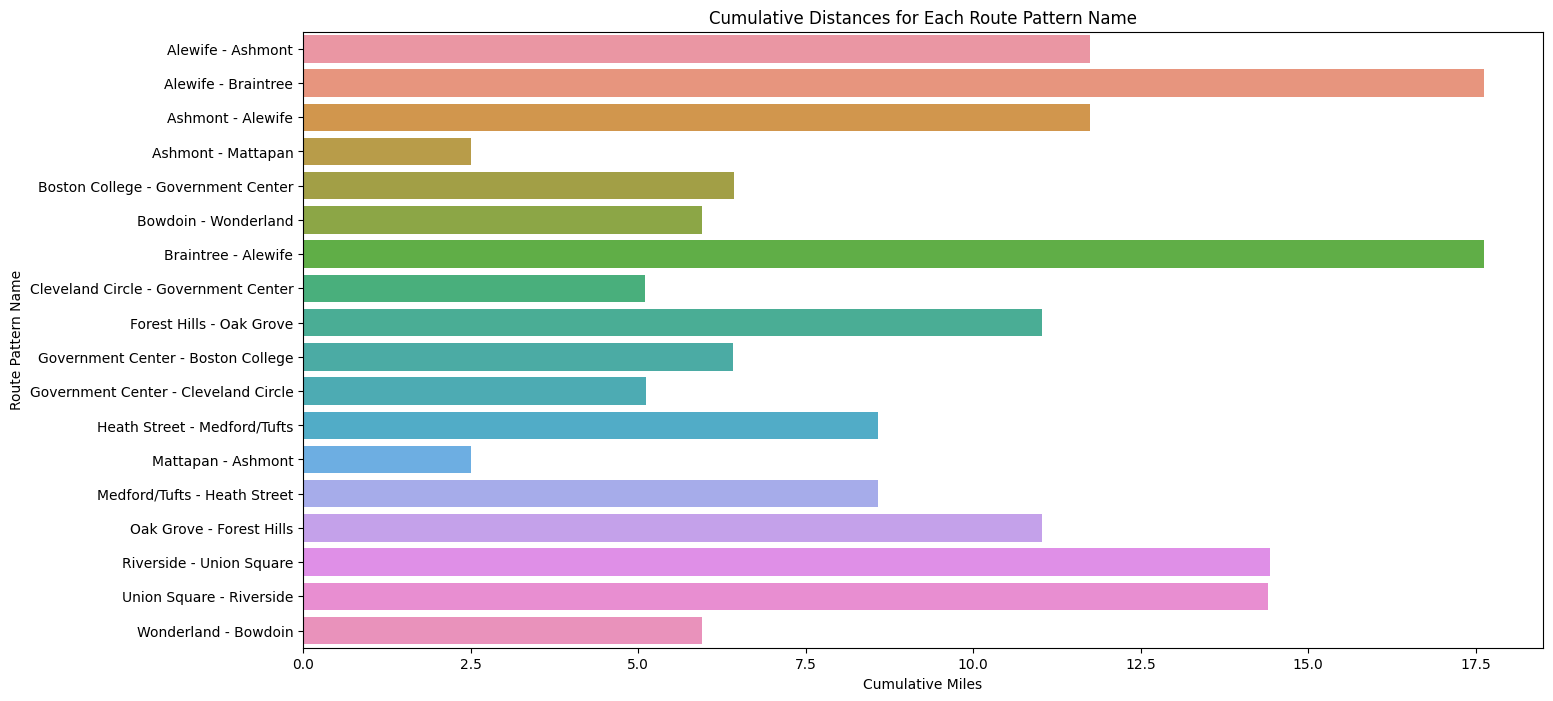

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by route_pattern_name, summing the cumulative distances
cumulative_distances_pattern = mbta_data.groupby('route_pattern_name')['cumulative_miles'].max().reset_index()

# Plotting the cumulative distances for each route pattern name
plt.figure(figsize=(16, 8))
sns.barplot(x='cumulative_miles', y='route_pattern_name', data=cumulative_distances_pattern, orient='h')
plt.title('Cumulative Distances for Each Route Pattern Name')
plt.xlabel('Cumulative Miles')
plt.ylabel('Route Pattern Name')
plt.show()


<ipython-input-31-b74bd74ab371>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='cumulative_miles', y='route_pattern_name', data=cumulative_distances_assembly, orient='h', palette='viridis', ci=None)


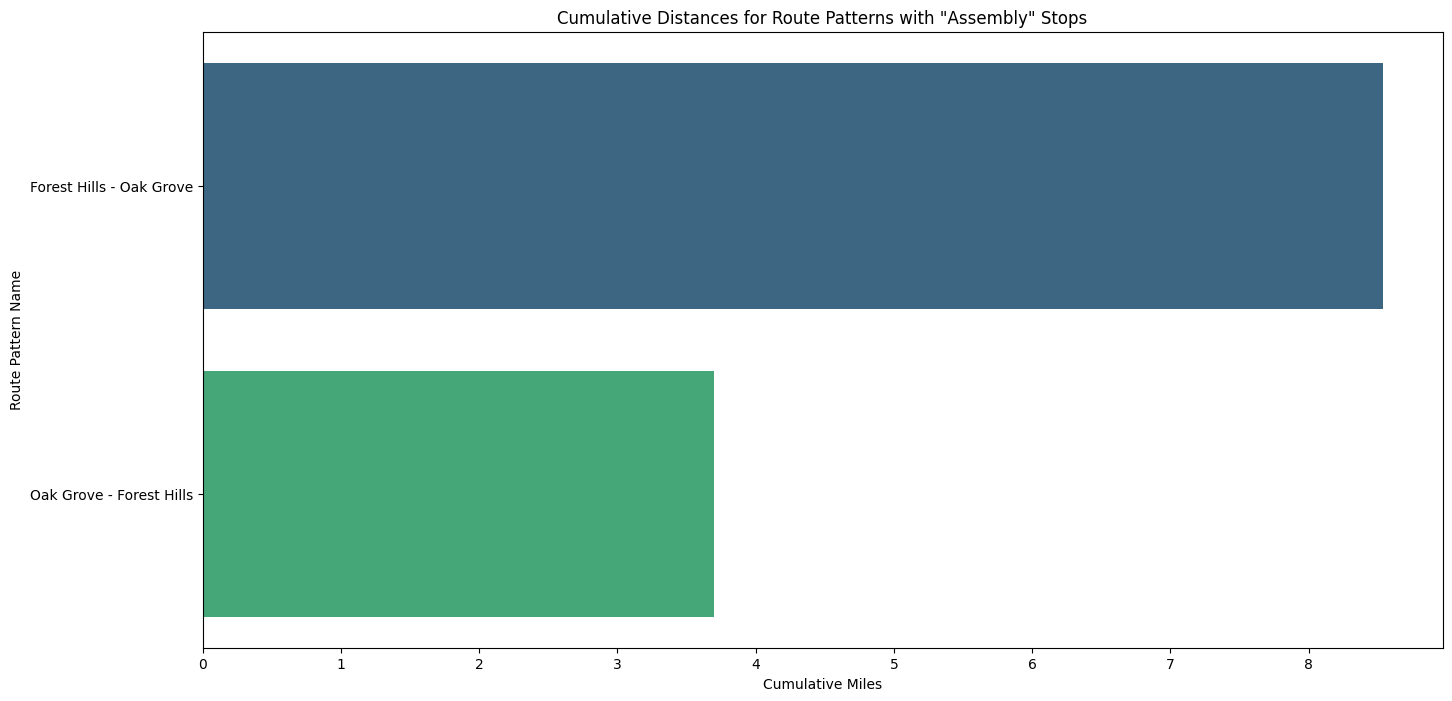

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for rows where either from_stop_name or to_stop_name contains the word "Assembly"
assembly_data = mbta_data[mbta_data['from_stop_name'].str.contains('Assembly') | mbta_data['to_stop_name'].str.contains('Assembly')]

# Group by route_pattern_name, summing the cumulative distances
cumulative_distances_assembly = assembly_data.groupby('route_pattern_name')['cumulative_miles'].max().reset_index()

# Plotting the cumulative distances for each route pattern with "Assembly" stops
plt.figure(figsize=(16, 8))
sns.barplot(x='cumulative_miles', y='route_pattern_name', data=cumulative_distances_assembly, orient='h', palette='viridis', ci=None)
plt.title('Cumulative Distances for Route Patterns with "Assembly" Stops')
plt.xlabel('Cumulative Miles')
plt.ylabel('Route Pattern Name')
plt.show()
